## Define different types of users
Active versus inactive 

0 versus 1

First hypothesis:
- you are inactive if you have less than 5 trips in two months

Second hypothesis:
- you are inactive if you have less than 50 miles in two months

### We have comb through everyone and determine whether they are active or inactive 

In [267]:
import pandas as pd
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [268]:
# create dataframes
driver = pd.read_csv("driver_ids.csv")
rider = pd.read_csv("ride_ids.csv")
timestamps = pd.read_csv("ride_timestamps.csv")

In [269]:
driver.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


In [270]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [271]:
timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


## Cleaning the rider df
- durations into minutes 
- distance into miles 
- fare based on minutes
- fare based on distance
- Actual total fare

In [272]:
# Convert the seconds into mintues 
rider['duration_min'] = rider['ride_duration'].apply(lambda x: x / 60)

In [273]:
# Convert meters into miles 
rider['distance_mi'] = rider['ride_distance'].apply(lambda x: x *  0.00062137)

In [274]:
# The fare purely based on the length in minutes 
rider['fare_duration'] = rider['duration_min'].apply(lambda x: x * .22)

In [275]:
# The fare purely based on the distance 
rider['fare_distance'] = rider['distance_mi'].apply(lambda x: x * 1.15)

In [276]:
# Fare based on the formula presented online
rider['total_fare'] = ((rider['fare_distance'] + rider['fare_duration']) * (1 + (0.01 * rider['ride_prime_time']))) + 2 + 1.75


In [277]:
# Set minimum and maximum on the fares 
rider['total_fare'] = rider['total_fare'].apply(lambda x: x if x >= 5 else 5)
rider['total_fare'] = rider['total_fare'].apply(lambda x: x if x <= 400 else 400)

In [278]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,duration_min,distance_mi,fare_duration,fare_distance,total_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.450000,1.125301,1.199000,1.294096,7.489644
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,13.483333,2.089046,2.966333,2.402403,9.118736
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,9.533333,2.039336,2.097333,2.345237,8.192570
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,55.633333,40.564898,12.239333,46.649632,77.361207
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,13.716667,2.556938,3.017667,2.940478,15.666290


## Combining timestamp and onboarding dates 


In [279]:
timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [280]:
# pivot the timestamps
pivot_timestamps = timestamps.pivot(index='ride_id', columns='event', values='timestamp')
pivot_timestamps.count()

event
accepted_at       194081
arrived_at        194080
dropped_off_at    194081
picked_up_at      194081
requested_at      194081
dtype: int64

In [281]:
# Preview the rides and the time stamp of each action 
pivot_timestamps.head()
pivot_timestamps.reset_index(level=0, inplace=True)

## This contains three crucial elements 
- driver_id
- ride_id
- driver_onboarding_date

In [282]:
# Merge driver_id, ride_id, and onboarding_date
driver_rider = pd.merge(rider[['driver_id','ride_id']], driver, on = 'driver_id', how = 'inner')
driver_rider.head()

,driver_id,ride_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,2016-03-29 00:00:00
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2016-03-29 00:00:00
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2016-03-29 00:00:00
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,2016-03-29 00:00:00
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2016-03-29 00:00:00


In [283]:
# merged the two data frames 
timestamps_driver = pd.merge(pivot_timestamps,driver_rider, on = 'ride_id', how = 'inner')
timestamps_driver.head()

,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,driver_id,driver_onboard_date
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21,0656192a402808805282e60761bda088,2016-04-30 00:00:00
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00
4,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:59:26,2016-05-31 15:46:23,2016-05-31 15:44:56,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00


In [284]:
# Reorder the columns
timestamps_driver = timestamps_driver[['driver_id', 'driver_onboard_date', 'ride_id','requested_at', 'accepted_at', 'arrived_at', 'picked_up_at', 'dropped_off_at']]
timestamps_driver.head()#['driver_onboard_date'][0]

,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30 00:00:00,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26


In [285]:
# Create a new dataframe  
timestamps_driver_datetime = pd.DataFrame()


# Change them into timestamp dates 
timestamps_driver_datetime['driver_id'] = timestamps_driver['driver_id']

timestamps_driver_datetime['driver_onboard_date'] = pd.to_datetime(timestamps_driver['driver_onboard_date'])

timestamps_driver_datetime['ride_id'] = timestamps_driver['ride_id']

timestamps_driver_datetime['requested_at'] = pd.to_datetime(timestamps_driver['requested_at'])

timestamps_driver_datetime['accepted_at'] = pd.to_datetime(timestamps_driver['accepted_at'])

timestamps_driver_datetime['arrived_at'] = pd.to_datetime(timestamps_driver['arrived_at'])

timestamps_driver_datetime['picked_up_at'] = pd.to_datetime(timestamps_driver['picked_up_at'])

timestamps_driver_datetime['dropped_off_at'] = pd.to_datetime(timestamps_driver['dropped_off_at'])


timestamps_driver_datetime.head()

,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26


,driver_id,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
driver_onboard_date,,,,,,,
2016-03-28,3849,3849,3849,3849,3849,3849,3849
2016-03-29,6937,6937,6937,6937,6936,6937,6937
2016-03-30,6001,6001,6001,6001,6001,6001,6001
2016-03-31,7199,7199,7199,7199,7199,7199,7199
2016-04-01,3294,3294,3294,3294,3294,3294,3294


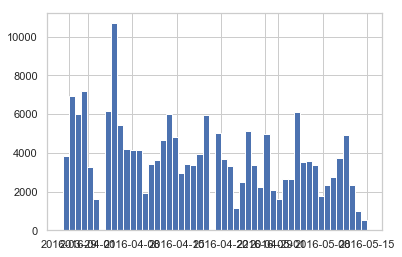

In [286]:
#timestamps_driver_datetime[timestamps_driver_datetime['driver_id'] == 'd967f5296732fa55266b5f1314e7447b'].count()

hist = timestamps_driver_datetime['driver_onboard_date'].hist(bins=50)

onboarding_amount = timestamps_driver_datetime.groupby(['driver_onboard_date']).count()
onboarding_amount.head()

In [287]:
# create a new data frame to contain frequency of riders 
df = pd.DataFrame()

df = rider.groupby(['driver_id'], as_index=False).size()

df = df.to_frame().reset_index()
df = df.rename(columns= {0: 'rides'})
df.head()

,driver_id,rides
0,002be0ffdc997bd5c50703158b7c2491,277
1,007f0389f9c7b03ef97098422f902e62,31
2,011e5c5dfc5c2c92501b8b24d47509bc,34
3,0152a2f305e71d26cc964f8d4411add9,191
4,01674381af7edd264113d4e6ed55ecda,375


In [288]:
# Create a dictionary of all the drivers as the key and the list of dates as a value
driver_ridedates = {}
for driver_id in df['driver_id']:
    # This is the dataframe with all the rides of a particular rider 
    temp_ride = timestamps_driver_datetime[timestamps_driver_datetime['driver_id'] == driver_id]
    
    #print(temp_ride.head())
    if temp_ride.shape[0] == 0:
        driver_ridedates[driver_id] = ['empty']
    elif temp_ride.shape[0] != 0:
        driver_ridedates[driver_id] = [temp_ride['driver_onboard_date'].tolist()[0]]
        driver_ridedates[driver_id].append(temp_ride['picked_up_at'].tolist())
        driver_ridedates[driver_id][1].sort()


In [289]:
driver_ridedates['056175954c78be4c4de7e80167b7e1f9']




['empty']

In [290]:
# The boolean is based on whether they had at least 5 rides per week average
# False means they didn't have enough 
# True means they reached the 5 rides a week quota 

driver_status = {}
for driver_id in df['driver_id']:
    if driver_ridedates[driver_id] == ['empty']:
        driver_status[driver_id] = False
    else:     
        driver_status[driver_id] = ((abs(driver_ridedates[driver_id][0] 
                                         - driver_ridedates[driver_id][1][-1])/7)*5).days <= len(driver_ridedates[driver_id][1])

        

In [291]:
# This just shows the amount of days between the initial onboarding and the last ride they accepted

driver_status_distance = {}
for driver_id in df['driver_id']:
    if driver_ridedates[driver_id] == ['empty']:
        driver_status_distance[driver_id] = 0
    else:     
        driver_status_distance[driver_id] = ((abs(driver_ridedates[driver_id][0] 
                                         - driver_ridedates[driver_id][1][-1]))).days 

In [292]:
#list(driver_status_distance.values())
#list(driver_status_distance)



In [293]:
driver_status_df = pd.DataFrame()

driver_status_df['driver_id'] = list(driver_status)

driver_status_df['driver_status'] = list(driver_status.values())

driver_status_df.head()

,driver_id,driver_status
0,002be0ffdc997bd5c50703158b7c2491,True
1,007f0389f9c7b03ef97098422f902e62,False
2,011e5c5dfc5c2c92501b8b24d47509bc,False
3,0152a2f305e71d26cc964f8d4411add9,True
4,01674381af7edd264113d4e6ed55ecda,True


In [294]:
driver_status_distance_df = pd.DataFrame()

driver_status_distance_df['driver_id'] = list(driver_status_distance)

driver_status_distance_df['driver_lifespan'] = list(driver_status_distance.values())

driver_status_distance_df.head()

,driver_id,driver_lifespan
0,002be0ffdc997bd5c50703158b7c2491,86
1,007f0389f9c7b03ef97098422f902e62,85
2,011e5c5dfc5c2c92501b8b24d47509bc,68
3,0152a2f305e71d26cc964f8d4411add9,64
4,01674381af7edd264113d4e6ed55ecda,56


In [295]:
np.mean(driver_status_distance_df['driver_lifespan'])

49.2017075773746

timestamps_driver.count()

In [296]:
timestamps_driver.head()

,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30 00:00:00,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26


## Use survival analytics to predict lifetime

In [297]:
driver_status_df.head()

,driver_id,driver_status
0,002be0ffdc997bd5c50703158b7c2491,True
1,007f0389f9c7b03ef97098422f902e62,False
2,011e5c5dfc5c2c92501b8b24d47509bc,False
3,0152a2f305e71d26cc964f8d4411add9,True
4,01674381af7edd264113d4e6ed55ecda,True


In [298]:
#lambda x: 1 if x == False else 0

In [299]:
driver_status_df['driver_status_bool'] = driver_status_df['driver_status'].apply(lambda x: 1 if x == False else 0)

In [300]:
driver_status_df.head()

,driver_id,driver_status,driver_status_bool
0,002be0ffdc997bd5c50703158b7c2491,True,0
1,007f0389f9c7b03ef97098422f902e62,False,1
2,011e5c5dfc5c2c92501b8b24d47509bc,False,1
3,0152a2f305e71d26cc964f8d4411add9,True,0
4,01674381af7edd264113d4e6ed55ecda,True,0


In [301]:
driver_status_distance_df.head()

,driver_id,driver_lifespan
0,002be0ffdc997bd5c50703158b7c2491,86
1,007f0389f9c7b03ef97098422f902e62,85
2,011e5c5dfc5c2c92501b8b24d47509bc,68
3,0152a2f305e71d26cc964f8d4411add9,64
4,01674381af7edd264113d4e6ed55ecda,56


In [302]:
# Survival Analysis Data Frame  
survival_dataframe = pd.merge(driver_status_df,driver_status_distance_df, on = 'driver_id', how = 'inner')

survival_dataframe.head()

,driver_id,driver_status,driver_status_bool,driver_lifespan
0,002be0ffdc997bd5c50703158b7c2491,True,0,86
1,007f0389f9c7b03ef97098422f902e62,False,1,85
2,011e5c5dfc5c2c92501b8b24d47509bc,False,1,68
3,0152a2f305e71d26cc964f8d4411add9,True,0,64
4,01674381af7edd264113d4e6ed55ecda,True,0,56


In [303]:
from lifelines import KaplanMeierFitter


In [304]:
# create a kmf object
kmf = KaplanMeierFitter() 

In [305]:
# Fit the data into the model
kmf.fit(survival_dataframe['driver_lifespan'], survival_dataframe['driver_status_bool'],label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter: fitted with 937 observations, 765 censored>

ModuleNotFoundError: No module named 'pandas.plotting._timeseries'

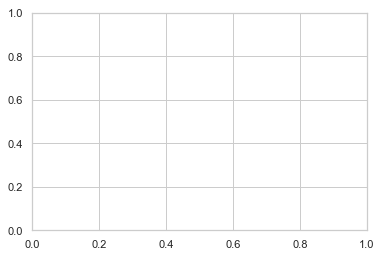

In [306]:
# Create an estimate
kmf.plot(ci_show=True) 



## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

In [ ]:
survival_dataframe.info()

## Cox Proportional Hazard Model


In [ ]:
from lifelines import CoxPHFitter


### Advice 1
Your team should recommend a definition, methodology or framework for calculating lifetime value.  Ideally, your recommendation should help you calculate a lifetime value for each individual driver.


### Advice 2
One of our follow up questions in the prompt is "Do all drivers act alike?  Are there specific segments of drivers that generate more value for Lyft than the average driver?".  So your LTV definition should be able to distinguish different drivers or at least cohorts of drivers. 


In [ ]:
rider.head()

In [ ]:
df.head()

In [ ]:
driver_status_distance_df.head()

In [ ]:
# Create a dataframe with the range of onboard to most recent ride &
# the number of rides each driver has given 
rides_per_day = pd.merge(df,driver_status_distance_df, on = 'driver_id', how = 'inner')
rides_per_day.head()

In [ ]:
# Add a new column that averages the number of rides a driver has per day 

rides_per_day['rides_per_day'] = (rides_per_day['rides'] / rides_per_day['driver_lifespan']) 

rides_per_day.head()

In [ ]:
rides_per_day

hist = rides_per_day['rides'].hist(bins=50)


In [ ]:
ax = rides_per_day.plot.scatter(x='driver_lifespan',
                       y='rides')

In [ ]:
rider.head()

In [ ]:
# Drop unneccessary columns
drive_sum = rider.drop(['ride_distance', 'ride_duration', 'fare_duration', 'fare_distance'], axis = 1)
# Group the riders by the sum 
drive_sum = drive_sum.groupby(['driver_id'],as_index=False).sum()

# Rename the columns to let people know that it's the sum of all rides 
drive_sum = drive_sum.rename(columns={"ride_prime_time": "ride_prime_time_sum", "duration_min": "duration_min_sum", "distance_mi":"distance_mi_sum", "fare":"fare_sum"})
drive_sum.head()

In [ ]:
driver_sum_total_fare = pd.merge(drive_sum,rides_per_day, on = 'driver_id', how = 'inner')
driver_sum_total_fare.head()

In [ ]:
ax2 = driver_sum_total_fare.plot.scatter(x='driver_lifespan',
                       y='total_fare')

# Linear Regression

In [317]:
#all of these is to check if any correlation
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['rides'])

0.5509852813939184

In [318]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['total_fare'])

0.5374074047316518

In [319]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['ride_prime_time_sum'])

0.45874643220488104

In [320]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['duration_min_sum'])

0.5387431548428506

In [321]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['distance_mi_sum'])

0.5278027197851141

In [322]:
#Do not vary so STD = 0 DOES NOT CORRELATE
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['rides_per_day'])

nan

In [323]:
#Creating the feature dataframe
X = pd.DataFrame(np.c_[driver_sum_total_fare['rides'],driver_sum_total_fare['total_fare'],driver_sum_total_fare['ride_prime_time_sum'],driver_sum_total_fare['duration_min_sum'],driver_sum_total_fare['distance_mi_sum']], columns = ['rides','total_fare','ride_prime_time_sum','duration_min_sum','distance_mi_sum'])

,rides,total_fare,ride_prime_time_sum,duration_min_sum,distance_mi_sum
0,190.0,3453.419687,5375.0,3687.300000,1081.362133
1,13.0,308.994506,625.0,341.616667,73.030237
2,16.0,468.927442,675.0,486.750000,167.554285
3,111.0,2569.866550,2050.0,2908.683333,914.183777
4,264.0,5287.086873,4700.0,5957.383333,1940.938672
5,157.0,2891.654771,2475.0,2997.966667,969.285005
6,35.0,662.241103,1200.0,840.783333,160.108408
7,211.0,4210.362722,3500.0,4485.916667,1531.436580
8,256.0,5118.254777,3975.0,5842.816667,1834.670111
9,44.0,1561.571428,225.0,1608.116667,994.017395


In [345]:
#Using the driver_lifespan as label
y = driver_sum_total_fare['driver_lifespan']

0      86
1      85
2      68
3      64
4      56
5      30
6      49
7      61
8      51
9      51
10     48
11     76
12     61
13     53
14     76
15     73
16      8
17     30
18     41
19     66
20      0
21     39
22     79
23     31
24     57
25     13
26     67
27     74
28     36
29     81
       ..
907    66
908    87
909    35
910    35
911    58
912    35
913    28
914    29
915    48
916    59
917    42
918    63
919    72
920    79
921    70
922    16
923    63
924    27
925     5
926    86
927    81
928    71
929    26
930     0
931    61
932     0
933    81
934    34
935    51
936    54
Name: driver_lifespan, Length: 937, dtype: int64

In [388]:
#Creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

In [326]:
#running linear reg

lin_reg_mod = LinearRegression()

In [327]:
lin_reg_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [328]:
pred = lin_reg_mod.predict(X_test)

In [329]:
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

test_set_r2 = r2_score(y_test, pred)

In [334]:
#printing RMSE, accuracy
print(test_set_rmse)
print(test_set_r2)


22.51550794432152
0.32815791479269907


# Log Regression

In [392]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, 
                                                    random_state=101)
#Creating training and testing 

In [393]:
# train['labels'] = labels
# le_rides = LabelEncoder()
# le_fare = LabelEncoder()
# le_prime = LabelEncoder()
# le_dura = LabelEncoder()
# le_dist = LabelEncoder()
# le_life = LabelEncoder()
# le_label = LabelEncoder()
# train['rides'] = le_rides.fit_transform(train['rides'])
# train['total_fare'] = le_fare.fit_transform(train['total_fare'])
# train['ride_prime_time_sum'] = le_prime.fit_transform(train['ride_prime_time_sum'])
# train['duration_min_sum'] = le_dura.fit_transform(train['duration_min_sum'])
# train['distance_mi_sum'] = le_dist.fit_transform(train['distance_mi_sum'])
# train['driver_lifespan'] = le_life.fit_transform(train['driver_lifespan'])
# train['driver_id'] = le_label.fit_transform(train['driver_id'])


# test['rides'] = le_rides.fit_transform(train['rides'])
# test['total_fare'] = le_fare.fit_transform(train['total_fare'])
# test['ride_prime_time_sum'] = le_prime.fit_transform(train['ride_prime_time_sum'])
# test['duration_min_sum'] = le_dura.fit_transform(train['duration_min_sum'])
# test['distance_mi_sum'] = le_dist.fit_transform(train['distance_mi_sum'])
# test['driver_lifespan'] = le_life.fit_transform(train['driver_lifespan'])


In [394]:
#Making log model
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='liblinear', multi_class='ovr')
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
#some labels in y_true don't appear in predictions = possibly bad accuracy b/x they become 0
set(y_test) - set(predictions)

{4,
 6,
 8,
 10,
 12,
 14,
 15,
 17,
 18,
 24,
 27,
 28,
 29,
 31,
 32,
 33,
 35,
 37,
 40,
 41,
 43,
 44,
 46,
 47,
 48,
 50,
 51,
 55,
 58,
 59,
 60,
 64,
 69,
 73,
 74,
 75,
 77,
 78,
 80,
 83,
 85,
 88,
 89}

In [395]:
from sklearn.metrics import f1_score as metrics
f1_score(y_test,predictions, average='weighted', labels=np.unique(predictions))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.08543699505612501